<a href="https://colab.research.google.com/github/jameszlj/NLP_with_python/blob/master/fast_ai_text_multi_label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.text import *

In [2]:
!wget https://github.com/jameszlj/NLP_with_python/raw/master/input/test.csv
!wget https://github.com/jameszlj/NLP_with_python/raw/master/input/train.csv

--2019-10-12 23:57:28--  https://github.com/jameszlj/NLP_with_python/raw/master/input/test.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jameszlj/NLP_with_python/master/input/test.csv [following]
--2019-10-12 23:57:28--  https://raw.githubusercontent.com/jameszlj/NLP_with_python/master/input/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60354593 (58M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]  57.56M   163MB/s    in 0.4s    

2019-10-12 23:57:29 (163 MB/s) - ‘test.csv’ saved [60354593/60354593]

--2019-10-12 23:57:30--  https://github.com/jame

In [3]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 3.5MB/s 
     |████████████████████████████████| 1.0MB 50.8MB/s 
     |████████████████████████████████| 655kB 45.4MB/s 
     |████████████████████████████████| 860kB 51.1MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609227 sha256=25cccfc53ea0becceb322c004dd1531d39f7f4cd643e40322c4647d476e3015f
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=f495ba5ce824fff67d868ef47ad220dffbc478cc3e7cb6c100f10fc6b2cc1047
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built regex sacremoses


In [0]:
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]


class MyNoTupleModel(BertForSequenceClassification):
    def forward(self, *args, **kwargs):
        return super().forward(*args, **kwargs)[0]

In [0]:
max_seq_len = 256
batch_size = 32
path = Path(".")
bert_model = "bert-base-uncased"

In [0]:
df = pd.read_csv("train.csv")
train, test = train_test_split(df,test_size=.4, random_state=4)
train, valid = train_test_split(train, test_size=.2,random_state=2)

In [8]:
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
34670,5c97b263cd98d32a,Facepalm* I was referring to you saying I hara...,0,0,0,0,0,0
59370,9f06c616ce4a564f,Response to James B Watson \n\nThank you for y...,0,0,0,0,0,0


In [9]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)
print(list(bert_tokenizer.vocab.items())[1000:1005])
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)

100%|██████████| 231508/231508 [00:00<00:00, 2664512.40B/s]

[('"', 1000), ('#', 1001), ('$', 1002), ('%', 1003), ('&', 1004)]


In [10]:
bert_fastai_tokenizer = Tokenizer(tok_func=tok_func, pre_rules=[], post_rules=[])
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
## preprocess databunch
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                                      tokenizer=bert_fastai_tokenizer,
                                      vocab=bert_vocab,
                                      include_bos=False,
                                      include_eos=False,
                                      text_cols="comment_text",
                                      label_cols=label_cols,
                                      bs=batch_size,
                                      collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
                                      )
databunch.show_batch()

text,target
"[CLS] "" dear situ ##sh , i understand your point . if you see this w ##p only a few are cited from inscriptions , most of them are well supported by book citations ( i mean i have given book citations as secondary , i have provided more than 2 - 3 citations as backup ) . please remember that those inscriptions are genuine and they are not manipulated",
"[CLS] "" sources , offers , and 1975 iraqi government ads in toronto star , new york times , and le monde it should be mentioned how different arab governments have said they would allow former jewish citizens of their nations to return and live in the arab world ( morocco , egypt , yemen , iraq , etc ) . putting aside if one considers this a credible offer",
"[CLS] "" israeli "" "" apartheid "" "" article look here and explain yourself : van ##dal ##ism is any addition , removal , or change of content made in a deliberate attempt to compromise the integrity of wikipedia . the most common types of van ##dal ##ism include the addition of ob ##sc ##eni ##ties or crude humor , page blank ##ing , or the insertion of nonsense into",
"[CLS] to the guy claiming s korea has more patents than the us , i did some research into wi ##po ' s latest database ( 2007 ) to stop both of you from making non - sense claims and reveal the truth . so here we go , straight from the horse ' s mouth : - south korea had the world ' s largest filing ##s per gdp",
"[CLS] "" google hits must not be taken as a yards ##tick in asian related af ##d ' s google hits must not be taken as a yards ##tick in asian related af ##d ' s . newspapers of vernacular languages may have millions of readers ##hip . for example , in india every state has its own language . there are more than 20 widely speaking native languages in",


In [11]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=6)
loss_func = nn.BCEWithLogitsLoss()
learn = Learner(databunch,
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

100%|██████████| 440473133/440473133 [00:06<00:00, 67885704.61B/s]


In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


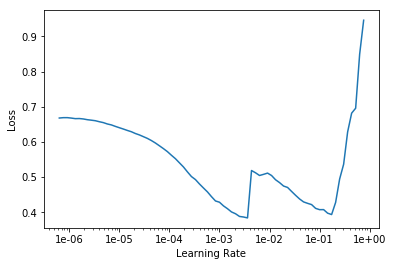

In [13]:
learn.recorder.plot()

In [1]:
learn.fit_one_cycle(4, 3e-5)

NameError: ignored